# 9章 CIFAR10を使った画像認識

In [1]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1

In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [3]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [4]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

### GPUチェック

In [5]:
# デバイスの割り当て

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 9.3 CNNの処理概要

In [7]:
# サンプルの手書き数字データを取得
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(
    root='./data',  train=True,  download=True,
    transform = transform)

image, label = train_set[0]
image = image.view(1,1,28,28)

In [8]:
# 対角線上にのみ重みを持つ特殊な畳み込み関数を作る
conv1 = nn.Conv2d(1, 1, 3)

# biasを0に
nn.init.constant_(conv1.bias, 0.0)

# weightを特殊な値に
w1_np = np.array([[0,0,1],[0,1,0],[1,0,0]])
w1 = torch.tensor(w1_np).float()
w1 = w1.view(1,1,3,3)
conv1.weight.data = w1


In [10]:
# 手書き数字に3回畳み込み処理を行う
image, label = train_set[0]
image = image.view(1,1,28,28)
w1 = conv1(image)
w2 = conv1(w1)
w3 = conv1(w2)
images = [image, w1, w2, w3]

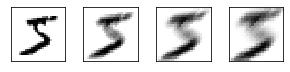

In [12]:
# 結果の画面表示

plt.figure(figsize=(5, 1))
for i in range(4):
    size = 28 - i*2
    ax = plt.subplot(1, 4, i+1)
    img = images[i].data.numpy()
    plt.imshow(img.reshape(size, size),cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 9.4 PyTorchでのCNN実装

### nn.Conv2d とnn.MaxPool2d

In [12]:
# CNN前半部分 レイヤー関数の定義

conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2,2))

In [14]:
# conv1の確認
print(conv1)

# conv1の内部変数のshape確認
print(conv1.weight.shape)
print(conv1.bias.shape)

# conv2の内部変数のshape確認
print(conv2.weight.shape)
print(conv2.bias.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])


In [15]:
# conv1のweight[0]とは、出力チャネル0用の重み
w = conv1.weight[0]

# waeight[0]のshapeと値の確認
print(w.shape)
print(w.data.numpy())

torch.Size([3, 3, 3])
[[[ 0.16924 -0.1249  -0.11169]
  [ 0.0797   0.08587 -0.08393]
  [-0.04177 -0.1863  -0.01923]]

 [[-0.06489 -0.05716 -0.03669]
  [-0.02132  0.07244  0.13748]
  [ 0.12473 -0.13688 -0.11032]]

 [[-0.12088  0.18639  0.0609 ]
  [ 0.11867  0.11812 -0.11608]
  [-0.07416 -0.10397  0.02524]]]


In [16]:
# ダミーで入力と同じサイズのTensorを生成
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

torch.Size([100, 3, 32, 32])


In [17]:
# CNNの前半部分をシミュレーションする

x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [18]:
# それぞれのshapeの確認

print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


### nn.Sequential

In [24]:
# 関数定義
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

In [25]:
# 動作テスト
outputs = features(inputs)

# 結果確認
print(outputs.shape)

torch.Size([100, 32, 14, 14])


### nn.Flatten

In [26]:
# 関数定義
flatten = nn.Flatten()

# 動作テスト
outputs2 = flatten(outputs)

# 結果確認
print(outputs2.shape)

torch.Size([100, 6272])


## 9.4 共通関数の定義

In [12]:
# 損失関数値計算用
def eval_loss(loader, device, net, criterion):
  
    # DataLoaderから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測値の計算
    outputs = net(inputs)

    #  損失値の計算
    loss = criterion(outputs, labels)

    return loss

In [13]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in train_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 順伝搬計算
            outputs = net(inputs)

            # 誤差計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # 重み変更
            optimizer.step()

            #予測値算出
            predicted = torch.max(outputs, 1)[1]

            #正解件数算出
            train_acc += (predicted == labels).sum()

            # 訓練データに対する損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)

            inputs = inputs.to(device)
            labels = labels.to(device)

            # 順伝搬計算
            outputs = net(inputs)

            # 誤差計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            #予測値算出
            predicted = torch.max(outputs, 1)[1]

            #正解件数算出
            val_acc += (predicted == labels).sum()

            # 検証データに対する損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [14]:
# 学習ログ解析

def evaluate_history(history):
    #損失関数値と精度の確認
    print(f'初期状態: 損失関数: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失関数: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失関数)
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失関数値')
    plt.title('学習曲線(損失関数)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

In [15]:
# 予測結果標示
def show_predict_result(net, loader, classes):

    # DataLoaderから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測値の計算
    outputs = net(inputs)
    predicted = torch.max(outputs,1)[1]
    images = images.to('cpu')

    # 最初の100個の表示
    plt.figure(figsize=(15, 20))
    for i in range(100):
        ax = plt.subplot(10, 10, i + 1)
        image = images[i].numpy()
        label_name = classes[labels[i]]
        predicted_name = classes[predicted[i]]
        img = np.transpose(image, (1, 2, 0))
        img2 = (img + 1)/2 
        plt.imshow(img2)
        if label_name == predicted_name:
            c = 'k'
        else:
            c = 'b'
        ax.set_title(label_name + ':' + predicted_name, c=c)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## 9.6 データ準備

In [16]:
# transformの定義

# transformer1 1次元化

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

# transformer2 正規化のみ実施

# 検証データ用 : 正規化のみ実施
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [17]:
# データ取得用関数 DataSet

# 訓練データセット 1次元版
train_set1 = datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=transform1)

# 検証データセット 1次元版
test_set1 = datasets.CIFAR10(
    root='./data', train=False, download=True, 
    transform=transform1)

# 訓練データセット 3次元版
train_set2 = datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=transform2)

# 検証データセット 3次元版
test_set2 = datasets.CIFAR10(
    root='./data', train=False, download=True, 
    transform=transform2)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### データセットの確認

In [18]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [19]:
# DataLoaderの定義

# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False) 

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader2 = DataLoader(test_set2,  batch_size=batch_size, shuffle=False) 


In [22]:
# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break

# train_loader2から1セット取得
for images2, labels2 in train_loader2:
    break

# それぞれのshape確認
print(images1.shape)
print(images2.shape)


torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


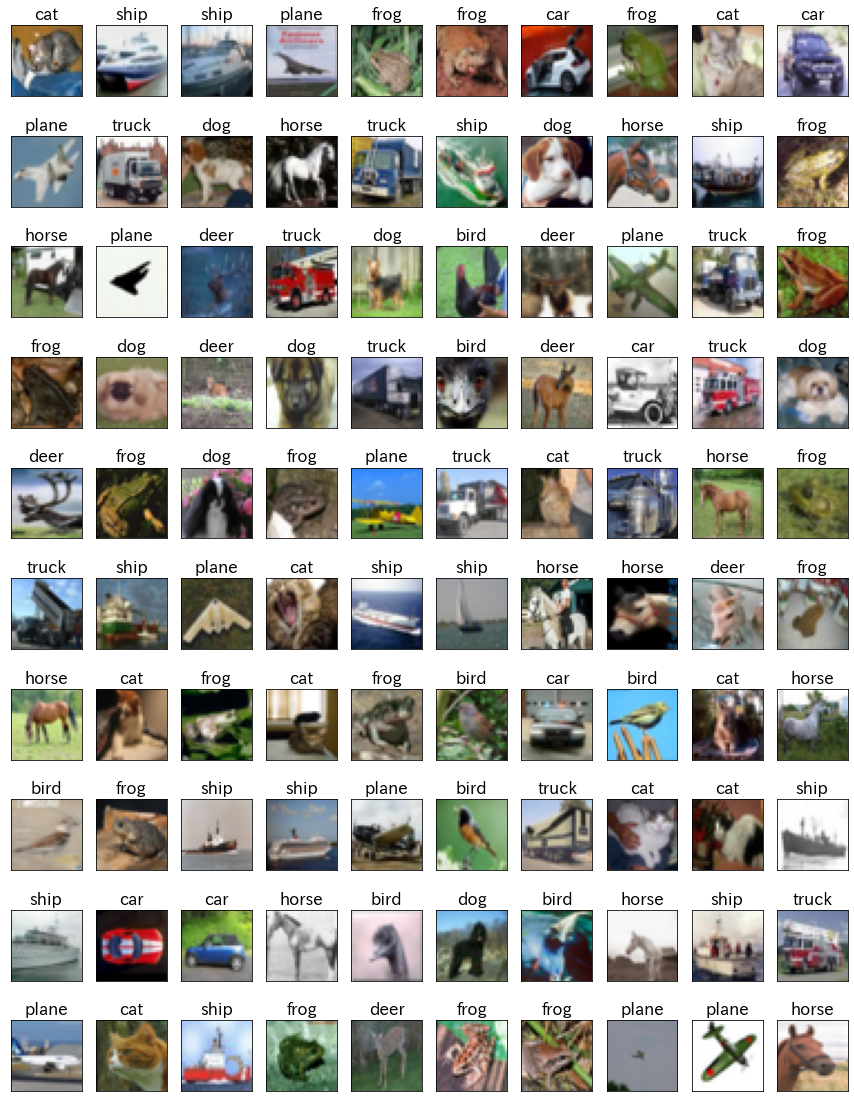

In [25]:
# 正解ラベル定義
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 最初の100個の表示
# DataLoaderから最初の1セットを取得する
for images, labels in test_loader2:
    break

plt.figure(figsize=(15, 20))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    image = images[i]
    label = labels[i]
    # TensorをNumPyに変換
    np_image = image.numpy().copy()
    # 軸の順番変更 (channel, row, column) -> (row, column, channel)
    img = np.transpose(np_image, (1, 2, 0))
    # 値の範囲を[-1, 1] -> [0, 1]に戻す
    img2 = (img + 1)/2 
    plt.imshow(img2)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 9.7 モデル定義(全結合版)

### 学習用パラメータ設定

In [28]:
# 入力次元数 今回は3*32*32=3072
n_input = image.view(-1).shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(set(list(labels.data.numpy())))

#   隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [29]:
# モデルの定義
# 784入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

### モデルインスタンスの生成とGPUの割り当て

In [ ]:
# インスタンスの生成
net = Net(n_input, n_output).to(device)

# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

In [ ]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=3072, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [ ]:
# モデルのサマリー表示

# summary(net, x0.view(-1).to(device))
summary(net, (3072,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         393,344
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 10]           1,290
Total params: 411,146
Trainable params: 411,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.57
Estimated Total Size (MB): 1.58
----------------------------------------------------------------


## 9.8 結果(全結合版)

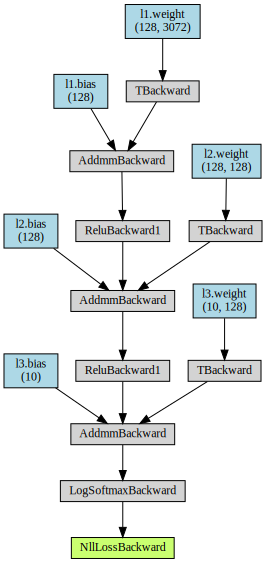

In [ ]:
# 損失の計算
loss = eval_loss(test_loader1, device, net, criterion)

# 損失関数のグラフ化
make_dot(loss, params=dict(net.named_parameters()))

### 学習

In [31]:
# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 学習率
lr = 0.01

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history = np.zeros((0,5))

In [33]:
# 学習

history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

Epoch [1/50], loss: 0.01942 acc: 0.32550 val_loss: 0.01781, val_acc: 0.38510
Epoch [2/50], loss: 0.01731 acc: 0.39884 val_loss: 0.01678, val_acc: 0.41670
Epoch [3/50], loss: 0.01651 acc: 0.42664 val_loss: 0.01618, val_acc: 0.44260
Epoch [4/50], loss: 0.01599 acc: 0.44338 val_loss: 0.01579, val_acc: 0.45240
Epoch [5/50], loss: 0.01560 acc: 0.45622 val_loss: 0.01551, val_acc: 0.45940
Epoch [6/50], loss: 0.01528 acc: 0.46860 val_loss: 0.01527, val_acc: 0.46610
Epoch [7/50], loss: 0.01500 acc: 0.47746 val_loss: 0.01505, val_acc: 0.47590
Epoch [8/50], loss: 0.01476 acc: 0.48856 val_loss: 0.01489, val_acc: 0.48190
Epoch [9/50], loss: 0.01452 acc: 0.49692 val_loss: 0.01478, val_acc: 0.48440
Epoch [10/50], loss: 0.01431 acc: 0.50380 val_loss: 0.01462, val_acc: 0.49160
Epoch [11/50], loss: 0.01411 acc: 0.51156 val_loss: 0.01451, val_acc: 0.49240
Epoch [12/50], loss: 0.01392 acc: 0.51760 val_loss: 0.01438, val_acc: 0.49390
Epoch [13/50], loss: 0.01374 acc: 0.52508 val_loss: 0.01425, val_acc: 0.5

初期状態: 損失関数: 0.01781 精度: 0.38510
最終状態: 損失関数: 0.01358 精度: 0.52830


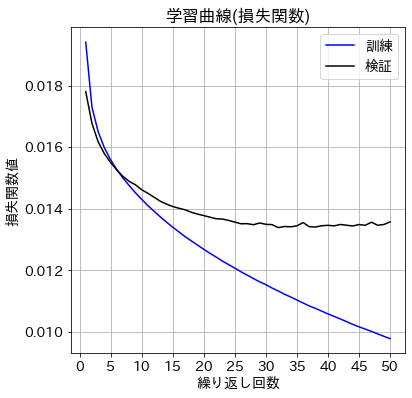

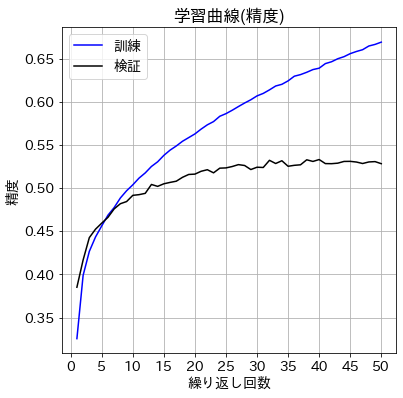

In [34]:
# 評価

evaluate_history(history)

## 9.9 モデル定義(CNN版)

In [53]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.classifier1 = nn.Linear(6272, n_hidden)
    self.classifier2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.classifier1,
       self.relu,
       self.classifier2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3       

### モデルインスタンスの生成と最適化関数、損失関数の定義

In [54]:
# インスタンスの生成
net = CNN(n_output, n_hidden).to(device)

# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

In [55]:
print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier1): Linear(in_features=6272, out_features=128, bias=True)
  (classifier2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [38]:
# モデルのサマリー表示

summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
            Conv2d-2           [-1, 32, 30, 30]             896
              ReLU-3           [-1, 32, 30, 30]               0
              ReLU-4           [-1, 32, 30, 30]               0
              ReLU-5           [-1, 32, 30, 30]               0
            Conv2d-6           [-1, 32, 28, 28]           9,248
            Conv2d-7           [-1, 32, 28, 28]           9,248
              ReLU-8           [-1, 32, 28, 28]               0
              ReLU-9           [-1, 32, 28, 28]               0
             ReLU-10           [-1, 32, 28, 28]               0
        MaxPool2d-11           [-1, 32, 14, 14]               0
        MaxPool2d-12           [-1, 32, 14, 14]               0
          Flatten-13                 [-1, 6272]               0
           Linear-14                  [

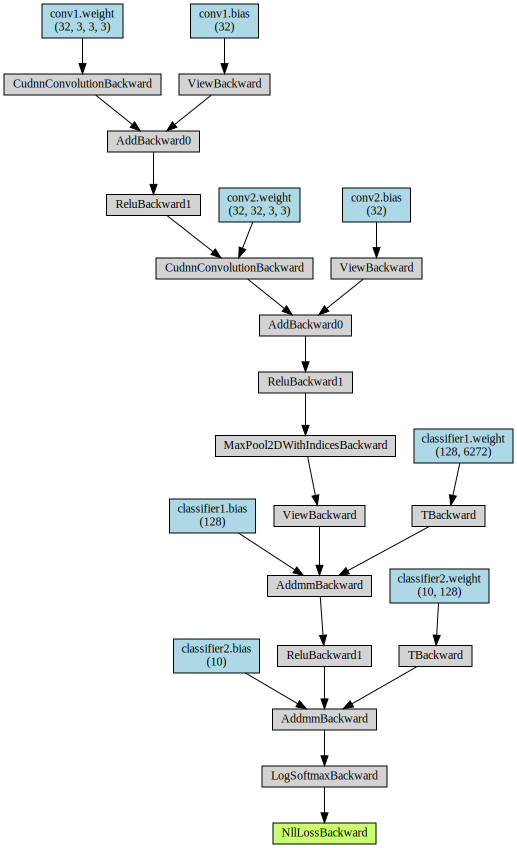

In [39]:
# 損失の計算
loss = eval_loss(test_loader2, device, net, criterion)

# 損失関数の計算グラフ化
make_dot(loss, params=dict(net.named_parameters()))

### 学習前初期設定

In [56]:
# 初期化
net = CNN(n_output, n_hidden).to(device)

# 学習率
lr = 0.01

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history = np.zeros((0,5))

## 9.10 結果(CNN版)

In [42]:
# 学習

history = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history)

Epoch [1/50], loss: 0.02129 acc: 0.24360 val_loss: 0.01896, val_acc: 0.33910
Epoch [2/50], loss: 0.01819 acc: 0.36102 val_loss: 0.01734, val_acc: 0.39370
Epoch [3/50], loss: 0.01678 acc: 0.40904 val_loss: 0.01624, val_acc: 0.42290
Epoch [4/50], loss: 0.01551 acc: 0.45334 val_loss: 0.01486, val_acc: 0.47450
Epoch [5/50], loss: 0.01451 acc: 0.48688 val_loss: 0.01410, val_acc: 0.49950
Epoch [6/50], loss: 0.01360 acc: 0.51700 val_loss: 0.01344, val_acc: 0.51590
Epoch [7/50], loss: 0.01289 acc: 0.54030 val_loss: 0.01267, val_acc: 0.54850
Epoch [8/50], loss: 0.01235 acc: 0.56410 val_loss: 0.01240, val_acc: 0.56030
Epoch [9/50], loss: 0.01193 acc: 0.58000 val_loss: 0.01235, val_acc: 0.55210
Epoch [10/50], loss: 0.01149 acc: 0.59712 val_loss: 0.01171, val_acc: 0.58130
Epoch [11/50], loss: 0.01114 acc: 0.60964 val_loss: 0.01174, val_acc: 0.58020
Epoch [12/50], loss: 0.01077 acc: 0.62316 val_loss: 0.01160, val_acc: 0.58820
Epoch [13/50], loss: 0.01044 acc: 0.63530 val_loss: 0.01130, val_acc: 0.6

初期状態: 損失関数: 0.01896 精度: 0.33910
最終状態: 損失関数: 0.02030 精度: 0.64460


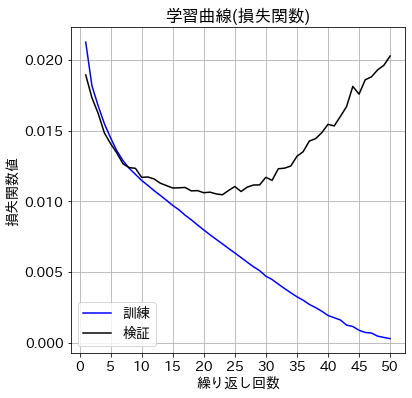

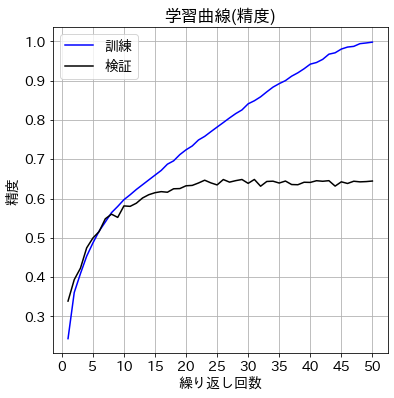

In [43]:
# 評価

evaluate_history(history)

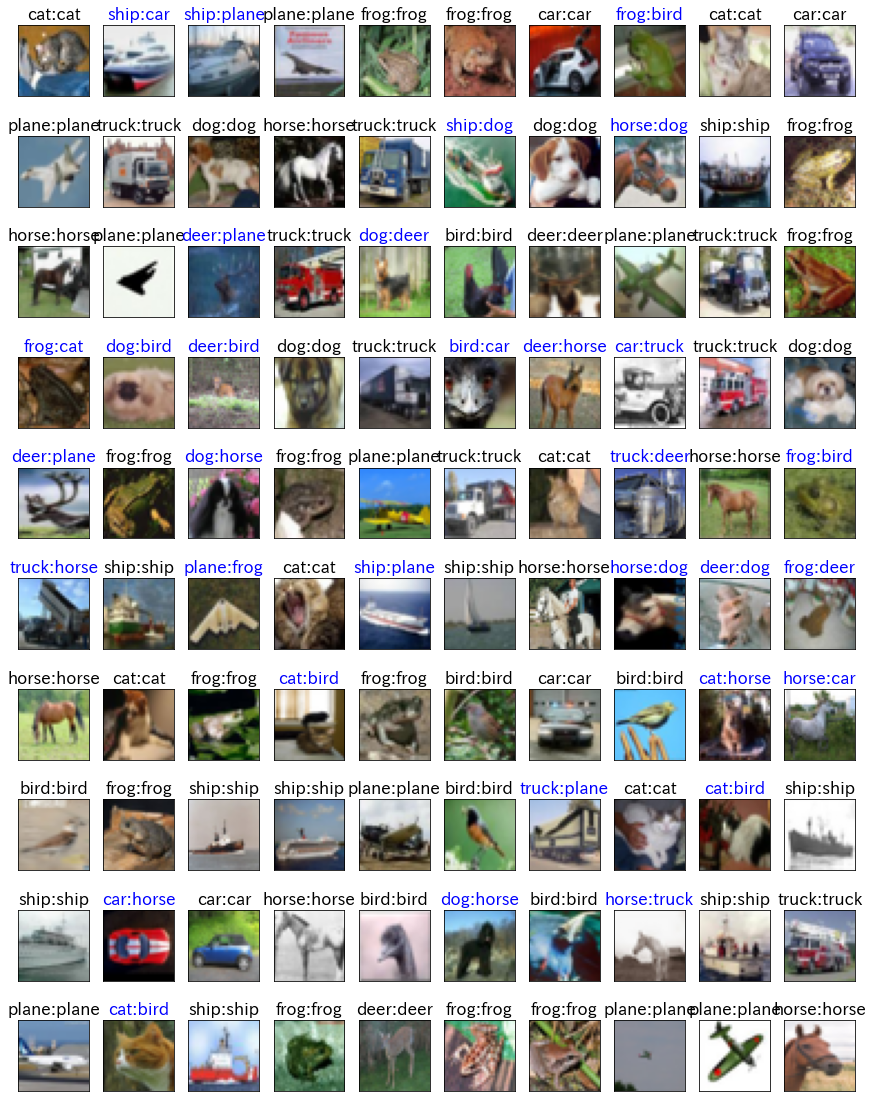

In [44]:
# 最初の100個の表示

show_predict_result(net, test_loader2, classes)

In [ ]:
# 初期化
net = CNN(n_output).to(device)

# 学習率
lr = 0.01

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 10

# 評価結果記録用
history2 = np.zeros((0,5))

In [ ]:
# 学習

history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, history2)

Epoch [1/10], loss: 0.01654 acc: 0.40104 val_loss: 0.01334, val_acc: 0.51360
Epoch [2/10], loss: 0.01209 acc: 0.56730 val_loss: 0.01114, val_acc: 0.60370
Epoch [3/10], loss: 0.00996 acc: 0.64880 val_loss: 0.00995, val_acc: 0.64930
Epoch [4/10], loss: 0.00841 acc: 0.70458 val_loss: 0.00940, val_acc: 0.67320
Epoch [5/10], loss: 0.00711 acc: 0.75130 val_loss: 0.00937, val_acc: 0.67970
Epoch [6/10], loss: 0.00588 acc: 0.79232 val_loss: 0.00960, val_acc: 0.67890
Epoch [7/10], loss: 0.00470 acc: 0.83468 val_loss: 0.01012, val_acc: 0.68330
Epoch [8/10], loss: 0.00357 acc: 0.87556 val_loss: 0.01116, val_acc: 0.68210
Epoch [9/10], loss: 0.00261 acc: 0.90850 val_loss: 0.01251, val_acc: 0.67790
Epoch [10/10], loss: 0.00182 acc: 0.93708 val_loss: 0.01492, val_acc: 0.67480
